# AIPI 590 - XAI | Assignment #2
### Interpretable ML
### Shaunak Badani


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shaunak-badani/XAI/blob/main/Assignment02/InterpretableML.ipynb)

In [1]:
import os
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy import stats

In [2]:
!rm -r ./sample_data

repo_name = "XAI" # Change to your repo name
git_path = f"https://github.com/shaunak-badani/{repo_name}.git" #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'Assignment02'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

rm: cannot remove './sample_data': No such file or directory
fatal: destination path 'XAI' already exists and is not an empty directory.
/content/XAI/Assignment02
InterpretableML.ipynb


In [3]:
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

In [4]:
filename = "WA_Fn-UseC_-Telco-Customer-Churn.csv"
churn_data = pd.read_csv(os.path.join(path, filename))

# Exploratory Data Analysis

In [5]:
churn_data.shape

(7043, 21)

In [6]:
churn_data = churn_data.replace({'Yes': 1, 'No': 0, 'No phone service': 0, 'No internet service': 0, ' ': 0}).infer_objects(copy=False)

<ipython-input-6-7b648db03076>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  churn_data = churn_data.replace({'Yes': 1, 'No': 0, 'No phone service': 0, 'No internet service': 0, ' ': 0}).infer_objects(copy=False)


In [7]:
numeric_columns_interpreted_as_object = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "TotalCharges"]
churn_data[numeric_columns_interpreted_as_object] = churn_data[numeric_columns_interpreted_as_object].apply(pd.to_numeric)

In [8]:
numeric_columns = churn_data.select_dtypes(include = 'number').columns.to_list()
print(len(numeric_columns))
churn_data[numeric_columns].describe()

16


,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,0.483033,0.299588,32.371149,0.903166,0.421837,0.286668,0.344881,0.343888,0.290217,0.384353,0.387903,0.592219,64.761692,2279.734304,0.265370
std,0.368612,0.499748,0.458110,24.559481,0.295752,0.493888,0.452237,0.475363,0.475038,0.453895,0.486477,0.487307,0.491457,30.090047,2266.794470,0.441561
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.500000,398.550000,0.000000
50%,0.000000,0.000000,0.000000,29.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,70.350000,1394.550000,0.000000
75%,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.850000,3786.600000,1.000000
max,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,118.750000,8684.800000,1.000000


In [9]:
columns_to_one_hot = ["gender", "InternetService", "Contract", "PaymentMethod"]
churn_data = pd.get_dummies(churn_data, columns = columns_to_one_hot, dtype = 'int64')

In [10]:
columns = set(churn_data.select_dtypes(include = 'number').columns.to_list()).difference({'Churn'})

## Checking assumptions of linear regression

#### Plotting each predictor vs target (churn)

In [11]:
len(columns)

27

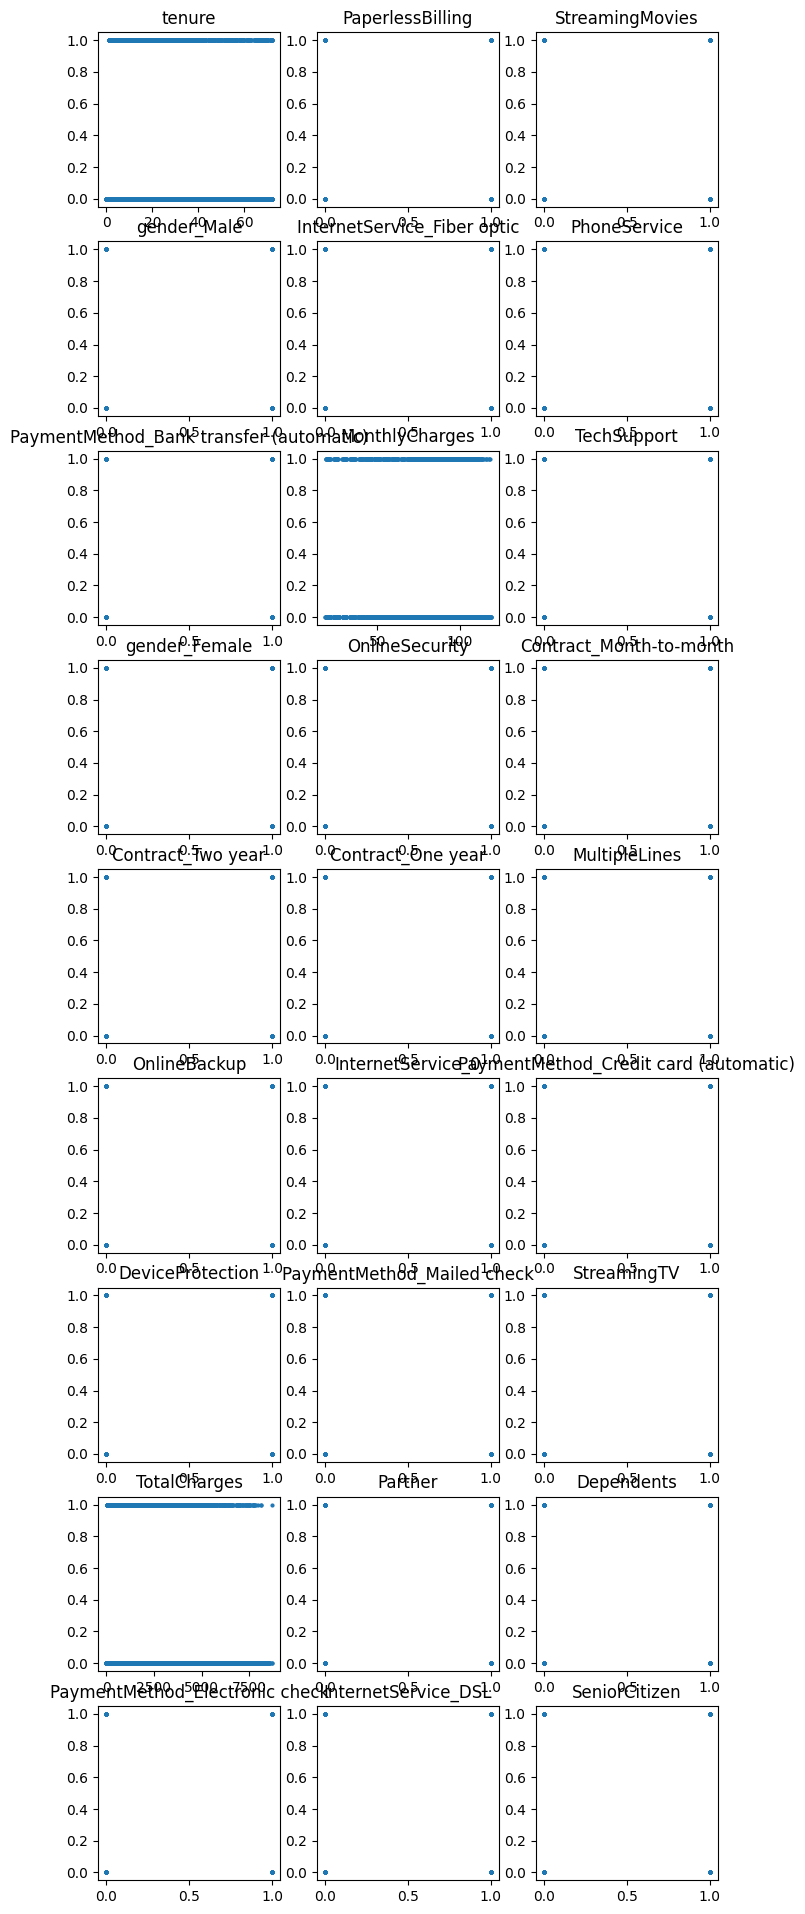

In [12]:
fig, axes = plt.subplots(9, 3, figsize = (8, 24))

for i, column in enumerate(columns):
  a, b = int(i / 3), int(i % 3)
  axes[a, b].set_title(f"{column}")
  axes[a, b].scatter(churn_data[column], churn_data["Churn"], s = 4)

#### Residuals vs predicted values

In [14]:
X = churn_data[list(columns)].to_numpy()
y = churn_data["Churn"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [15]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_preds_test = model.predict(X_test_scaled)
residuals = y_test - y_preds_test

Text(0, 0.5, 'Residuals')

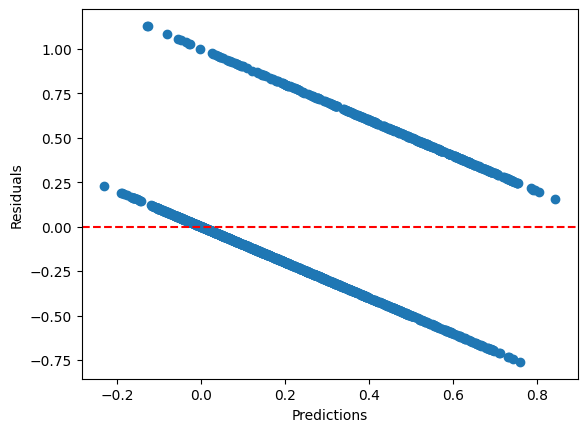

In [17]:
plt.scatter(y_preds_test, residuals)
plt.xlabel("Predictions")
plt.axhline(y=0, color='r', linestyle='--')
plt.ylabel("Residuals")

It's difficult to interpret linearity from the above plot since the y value is either $ 1 - x $ or $ -x $ leading to two straight lines forming in the above plot.

No funnels in the residual plots, so we can say that Homoscedasticity is observed.

## Independence of Observations

#### Durbin-Watson Test

In [18]:
diff = np.diff(residuals)
dw = np.sum(diff**2) / np.sum(residuals**2)
print(dw)

2.064935829142453


- The Durbin-Watson value is close to 2, so there is no first order auto-correlation.

## Normality of Residuals

#### Q-Q plots of residuals



((array([-3.29516378, -3.03723403, -2.89375266, ...,  2.89375266,
          3.03723403,  3.29516378]),
  array([-0.76053836, -0.74404933, -0.73521432, ...,  1.08099995,
          1.12543441,  1.12847713])),
 (0.37607786116203545, -0.001462772727989932, 0.9801582146637087))

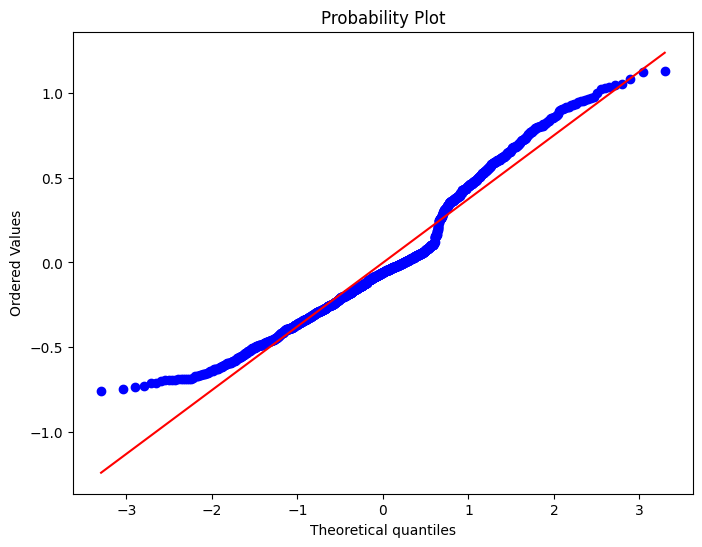

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot = ax)

Since the points are following a roughly 45 degree line, the residuals can be said to be normally distributed.